In [337]:
import torch
from torch import multiprocessing
import numpy as np
import matplotlib.pyplot as plt


import sys
sys.path.append('/home/ksh-server/workspace/ICUFN')
from my_clustering.my_vmas.scenarios.navigation_random import Scenario

In [338]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device

env = Scenario()
world = env.make_world(
        device=device,
        n_agents=4,
        batch_dim=1
    )


In [339]:
def world_reset(env):
    env.reset_world_at()
    agents = env.world.agents
    targets = env.targets
    finished_position = env.finished_pos
    
    return agents, targets, finished_position

In [340]:
def initial_render(agents, targets, finished_position):
    map_size = 2

    # 플롯 생성
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(-map_size, map_size)
    ax.set_ylim(-map_size, map_size)
    ax.set_title("Agent and Target Distribution")

    # 에이전트 플로팅 (파란색 원)
    for i, agent in enumerate(agents):
        x, y = agent.state.pos.squeeze().tolist()
        ax.add_patch(plt.Circle((x, y), agent.shape.radius, color=agent.color, alpha=1, label=f"Agent_{i+1}"))

    for target in targets:
        x, y = target.state.pos.squeeze().tolist()
        label = "target" if targets[0] == target else None
        ax.add_patch(plt.Circle((x, y), target.shape.radius, color="black", alpha=1, label=label))
        
    for pos in finished_position:
        x, y = pos[0].squeeze().tolist()
        label = 'finished_position' if finished_position[0] == pos else None
        ax.add_patch(plt.Circle((x, y), targets[0].shape.radius, color='gray', alpha=1, label=label))

    # 범례 및 표시
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

In [341]:
def numpy_pos(agents, targets, finished_position):
    agents_pos = []
    for agent in agents:
        x, y = agent.state.pos.squeeze().tolist()
        agents_pos.append([x, y])
    agents_pos = np.array(agents_pos)
    
    targets_pos = []
    targets_cost = []
    for target in targets:
        x, y = target.state.pos.squeeze().tolist()
        targets_pos.append([x, y])
        cost = target.cost.item()
        targets_cost.append(cost)
    targets_pos = np.array(targets_pos)
    targets_cost = np.array(targets_cost)

    finished_pos = []
    for pos in finished_position:
        x, y = pos[0].squeeze().tolist()
        finished_pos.append([x, y])
    finished_pos = np.array(finished_pos)
    
    return agents_pos, targets_pos, targets_cost, finished_pos

In [342]:
agents, targets, finished_position = world_reset(env)

In [343]:
agents_pos, targets_pos, targets_cost, finished_pos = numpy_pos(agents, targets, finished_position)


In [344]:
from sklearn.cluster import KMeans
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

In [345]:
# agents_pos
# targets_pos, targets_cost
# finished_pos

In [346]:
n_clusters = len(agents)

In [347]:
def kmeans_clust(targets_pos):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(targets_pos)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers

In [348]:
def kmeans_cost_division_clust(targets_pos, targets_cost):
    # 타겟 증식
    for i, cost in enumerate(targets_cost):
        count = cost // 10 - 1
        for _ in range(count):
            targets_pos = np.concatenate((targets_pos, np.expand_dims(targets_pos[i], axis=0)), axis=0)
            
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(targets_pos)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers, targets_pos

In [349]:
def zip_clusters(agents, targets, labels):
    clusters = [[] for _ in range(len(agents))]
    for target, label in zip(targets, labels):
        clusters[label].append(target)
    return clusters

In [350]:
def clusters_render(agents, clusters, centers, func= lambda target : target.state.pos.squeeze().tolist()):
    plt.Figure(figsize=(4, 4))
    for i, cluster in enumerate(clusters):
        for j, target in enumerate(cluster):
            x, y = func(target)
            plt.scatter(x, y, color = agents[i].color, label = f"agent{i+1}" if j == 0 else "")
            
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='*', alpha=0.2, s=200, label='Centers')
    plt.title("Target Position Clustering")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
    plt.grid(True)
    plt.axis('equal')
    plt.show()

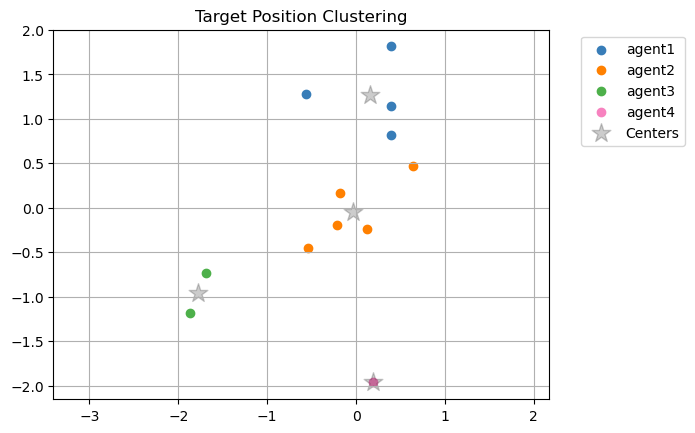

In [351]:
labels, centers = kmeans_clust(targets_pos)
clusters = zip_clusters(agents, targets, labels)
clusters_render(agents, clusters, centers)

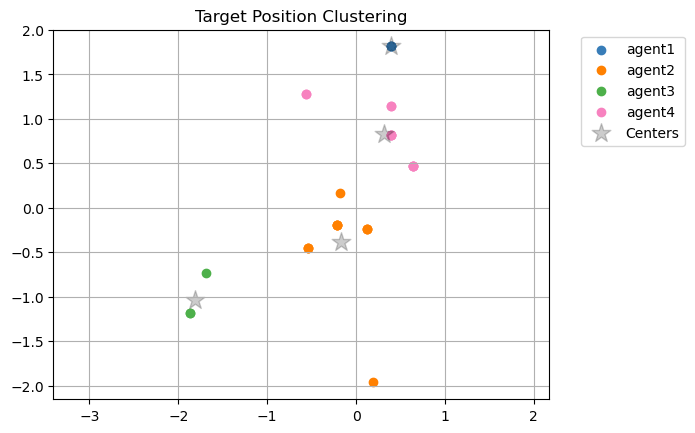

30
120
30
120


In [ ]:
labels, centers, expended = kmeans_cost_division_clust(targets_pos, targets_cost)
clusters = zip_clusters(agents, expended, labels)
clusters_render(agents, clusters, centers, func=lambda target: target)

# 분배된 코스트
for cluster in clusters:
    print(len(cluster)*10)

In [354]:
# tsp의 영역

In [355]:
def list_pos(agents_pos, clusters, finished_pos):
    agents_pos = agents_pos.tolist()
    finished_pos = finished_pos.tolist()
    
    clusters_pos = [[] for _ in range(len(agents_pos))]
    for i, targets in enumerate(clusters):
        for target in targets:
            x, y = target.state.pos.squeeze().tolist()
            clusters_pos[i].append([x, y])
    
    return agents_pos, clusters_pos, finished_pos

In [356]:
agents_pos, clusters_pos, finished_pos = list_pos(agents_pos, clusters, finished_pos)

AttributeError: 'numpy.ndarray' object has no attribute 'state'

In [ ]:
def clusters_tsp(agents_pos, clusters, finished_pos):
    

SyntaxError: incomplete input (1603936969.py, line 2)